In [1]:
import numpy as np
import cv2
import os
import csv
import rasterio
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample
import random
from torch.utils.data import Dataset
import tifffile
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
from model import * 

In [17]:
root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
train_path=root_dir+"txt/train.txt"
val_path=root_dir+"txt/val.txt"
test_path=root_dir+"txt/test.txt"
with open(train_path, "r") as t:
    lines_train =t.readlines()
    list_train=[i[:-1] for i in lines_train]
with open(val_path, "r") as v:
    lines_val =v.readlines()
    list_val=[i[:-1] for i in lines_val]   
with open(test_path, "r") as x:
    lines_test =x.readlines()
    list_test=[i[:-1] for i in lines_test]   

In [3]:
class SARDataset(Dataset):

    def __init__(self, data_list, preprocess_func):
        self.data_list = data_list
        self.preprocess_func = preprocess_func

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, i):
        return self.preprocess_func(self.data_list[i])

def processAndAugment(data):
    
    root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
    
    S1 = root_dir+"S1/"+data+"_S1Hand.tif"
    DEM = root_dir+"DEM/"+data+"_DEM.tif"
    Label=root_dir+"Label/"+data+"_LabelHand.tif"
    
    S1_data=np.nan_to_num(tifffile.imread(S1))
    DEM_data=tifffile.imread(DEM)
    Label_data=np.uint8(rasterio.open(Label).read())
   # Label_data[Label_data==255]=2
    #location = np.argwhere(Label_data==2).tolist()    
    
    arr_x = np.clip(S1_data, -50, 1)
    arr_x = (arr_x + 50) / 51
    S1_0_NORM = arr_x[0]
    S1_1_NORM = arr_x[1]

    #S1_data=np.nan_to_num(rasterio.open(S1).read())
   # DEM_data=rasterio.open(DEM).read()
    #Label_data=np.uint8(rasterio.open(Label).read())
    #Label_data[Label_data==255]=2
    #location = np.argwhere(Label_data==2).tolist()
    
    DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
#    S1_0_NORM = (S1_data[0] - np.min(S1_data[0])) / (np.max(S1_data[0]) - np.min(S1_data[0]))
#    S1_1_NORM = (S1_data[1] - np.min(S1_data[1])) / (np.max(S1_data[1]) - np.min(S1_data[1]))

   # for l in location:
   #     DEM_NORM[l[0],l[1],l[2]]=0
   #     S1_0_NORM[l[1],l[2]]=0
   #     S1_1_NORM[l[1],l[2]]=0
    
    S1_0_NORM = np.expand_dims(S1_0_NORM, axis=0)
    S1_1_NORM = np.expand_dims(S1_1_NORM, axis=0)
    S0_NORM = torch.from_numpy(S1_0_NORM)#.float
    S1_NORM = torch.from_numpy(S1_1_NORM)#.float
    DEM = torch.from_numpy(DEM_NORM)#.float
    Label = torch.from_numpy(Label_data).squeeze().long()
    
    SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=1)
    #x= torch.tensor(SUM, dtype=torch.float32)
    #X_data = np.stack((S1_0_NORM, S1_1_NORM, DEM_NORM), axis=0)  
    
   # x_transforms = transforms.Compose([
  #  transforms.ToTensor(),
  #  transforms.Normalize([0.5], [0.5])])

# mask只需要转换为tensor
  #  y_transforms = transforms.ToTensor()
    
    return SUM,Label

In [4]:
train_dataset = SARDataset(list_train, processAndAugment)
val_dataset = SARDataset(list_val, processAndAugment)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=0)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
len(train_dataloader.dataset)

312

In [12]:
def train_model(model, criterion, optimizer, dataload, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [13]:
def train():
    model = UNet().to(device)
    batch_size = 2
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    train_dataset = SARDataset(list_train, processAndAugment)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    train_model(model, criterion, optimizer, train_dataloader)

In [14]:
train()

In [34]:
def train_model(model, criterion, optimizer, dataload, num_epochs=200):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [7]:
model = UNet()
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_dataset = SARDataset(list_train, processAndAugment)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_dataset = SARDataset(list_val, processAndAugment)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

In [8]:
training_losses = []
training_accuracies = []
training_ious = []

def train_loop(inputs, labels, net, optimizer):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy

    # zero the parameter gradients
    optimizer.zero_grad()
    net = net.to(device)

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    ###scheduler.step()

    running_loss += loss.item()
    running_iou += computeIOU(outputs, labels)
    running_accuracy += computeAccuracy(outputs, labels)
    running_count += 1
    

In [9]:
valid_losses = []
valid_accuracies = []
valid_ious = []

def validation_loop(validation_data_loader, net):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    global max_valid_iou

    global training_losses
    global training_accuracies
    global training_ious
    global valid_losses
    global valid_accuracies
    global valid_ious

    net = net.eval()
    net = net.to(device)
    count = 0
    iou = 0
    loss = 0
    accuracy = 0
    with torch.no_grad():
        for (images, labels) in validation_data_loader:
            net = net.to(device)
            outputs = net(images.to(device))
            valid_loss = criterion(outputs, labels.to(device))
            valid_iou = computeIOU(outputs, labels.to(device))
            valid_accuracy = computeAccuracy(outputs, labels.to(device))
            iou += valid_iou
            loss += valid_loss
            accuracy += valid_accuracy
            count += 1

    iou = iou / count
    accuracy = accuracy / count

    if iou > max_valid_iou:
        max_valid_iou = iou
        aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/"
        file= "{}_{}_{}.cp".format(RUNNAME, i, iou.item())     
        save_path = aaa+file
        torch.save(net.state_dict(), save_path)
        print("model saved at", save_path)

    loss = loss / count
    print("Training Loss:", running_loss / running_count)
    print("Training IOU:", running_iou / running_count)
    print("Training Accuracy:", running_accuracy / running_count)
    print("Validation Loss:", loss)
    print("Validation IOU:", iou)
    print("Validation Accuracy:", accuracy)


    training_losses.append(running_loss / running_count)
    training_accuracies.append(running_accuracy / running_count)
    training_ious.append(running_iou / running_count)
    valid_losses.append(loss)
    valid_accuracies.append(accuracy)
    valid_ious.append(iou)

In [10]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer,  train_loader):
    for inputs, labels in train_loader:
        train_loop(inputs.to(device), labels.to(device), net.to(device), optimizer)

        
        
def  train_validation_loop(net, optimizer,train_loader,
                          valid_loader, num_epochs, cur_epoch):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    net = net.train()
    running_loss = 0
    running_iou = 0
    running_count = 0
    running_accuracy = 0

    for i in range(num_epochs):
        train_epoch(net, optimizer, train_loader)
    clear_output()

    print("Current Epoch:", cur_epoch)
    validation_loop(valid_loader, net)


In [11]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

for i in range(start, 5):
    train_validation_loop(model, optimizer, train_dataloader, val_dataloader, 5, i)
    epochs.append(i)
    x = epochs
    plt.plot(x, training_losses, label='training losses')
    plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(x, training_ious, 'tab:purple', label='training iou')
    plt.plot(x, valid_losses, label='valid losses')
    plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
    plt.plot(x, valid_ious, 'tab:green',label='valid iou')
    plt.legend(loc="upper left")

    display(plt.show())

    print("max valid iou:", max_valid_iou)

<ipython-input-4-9529cc09e45f>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x= torch.tensor(SUM, dtype=torch.float32)
<ipython-input-4-9529cc09e45f>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x= torch.tensor(SUM, dtype=torch.float32)
<ipython-input-4-9529cc09e45f>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x= torch.tensor(SUM, dtype=torch.float32)


In [ ]:
running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

In [ ]:
def train_model(model, criterion, optimizer, dataload, val, num_epochs=200):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [ ]:
running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

In [7]:
def computeIOU(output, target):
    
    output = torch.argmax(output, dim=1).flatten() 
    target = target.flatten()

    no_ignore = target.ne(255).cuda()
    output = output.masked_select(no_ignore)
    target = target.masked_select(no_ignore)
    intersection = torch.sum(output * target)
    union = torch.sum(target) + torch.sum(output) - intersection
    iou = (intersection + .0000001) / (union + .0000001)

    return iou

def computeAccuracy(output, target):
    output = torch.argmax(output, dim=1).flatten() 
    target = target.flatten()

    no_ignore = target.ne(255).cuda()
    output = output.masked_select(no_ignore)
    target = target.masked_select(no_ignore)
    correct = torch.sum(output.eq(target))

    return correct.float() / len(target)

In [8]:
model = UNet().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
train_dataset = SARDataset(list_train, processAndAugment)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4)
val_dataset = SARDataset(list_val, processAndAugment)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

In [9]:
def train_model(model, criterion, optimizer, dataload, val, num_epochs=2):
    global running_loss
    global running_iou
    global running_count
    global running_accuracy
    global max_valid_iou
    
    global training_losses
    global training_accuracies
    global training_ious
    global valid_losses
    global valid_accuracies
    global valid_ious
    global epochs 
    max_valid_iou = 0
    
    training_losses = []
    training_accuracies = []
    training_ious = []
    valid_losses = []
    valid_accuracies = []
    valid_ious = []
    epochs = []
   
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        val_size = len(val.dataset)
        running_loss = 0
        running_iou = 0
        running_count = 0
        running_accuracy = 0
        #epoch_loss = 0
        #step = 0
        for x, y in dataload:
            x= torch.tensor(x, dtype=torch.float32)
            #y= torch.tensor(y, dtype=torch.float32)
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_iou += computeIOU(outputs, labels)
            running_accuracy += computeAccuracy(outputs, labels)
            running_count += 1
            #print("%d/%d,train_loss:%0.3f" % (running_count, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        #print("epoch %d loss:%0.3f" % (epoch, running_loss/running_count))
        
        model = model.eval()
        count = 0
        iou = 0
        loss = 0
        accuracy = 0
        with torch.no_grad():
            for x, y in val:
                x= torch.tensor(x, dtype=torch.float32)
                model = model.to(device)
                inputs = x.to(device)
                labels = y.to(device)
                outputs = model(inputs)
                valid_loss = criterion(outputs, labels)
                valid_iou = computeIOU(outputs, labels)
                valid_accuracy = computeAccuracy(outputs, labels)
                iou += valid_iou
                loss += valid_loss
                accuracy += valid_accuracy
                count += 1

        iou = iou / count
        accuracy = accuracy / count

        if iou > max_valid_iou:
            max_valid_iou = iou
            aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/"
            file= "{}_{}.pth".format(epoch, iou.item())     
            save_path = aaa+file
            torch.save(model.state_dict(), save_path)
            print("model saved at", save_path)

        loss = loss / count
        print("epoch:" ,epoch)
        print("Training Loss:", running_loss / running_count)
        print("Training IOU:", (running_iou / running_count).item())
        print("Training Accuracy:", (running_accuracy / running_count).item())
        print("Validation Loss:", loss.item())
        print("Validation IOU:", iou.item())
        print("Validation Accuracy:", accuracy.item())


        training_losses.append((running_loss / running_count))
        training_accuracies.append((running_accuracy / running_count).item())
        training_ious.append((running_iou / running_count).item())
        valid_losses.append(loss.item())
        valid_accuracies.append(accuracy.item())
        valid_ious.append(iou.item())    
        epochs.append(epoch)
        
        
        
        
        
#    aaa="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/"
#    torch.save(model.state_dict(), aaa+'weights_%d.pth' % epoch)
#    return model

In [10]:
import warnings
warnings.filterwarnings("ignore")
train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=500)

Epoch 0/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/0_0.0695267990231514.pth
epoch: 0
Training Loss: 0.9733288479156983
Training IOU: 0.10613615065813065
Training Accuracy: 0.7110305428504944
Validation Loss: 1.0053147077560425
Validation IOU: 0.0695267990231514
Validation Accuracy: 0.643997311592102
Epoch 1/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/1_0.13605396449565887.pth
epoch: 1
Training Loss: 0.30332367400376076
Training IOU: 0.10697116702795029
Training Accuracy: 0.8995404243469238
Validation Loss: 0.21955057978630066
Validation IOU: 0.13605396449565887
Validation Accuracy: 0.9284829497337341
Epoch 2/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/2_0.22350101172924042.pth
epoch: 2
Training Loss: 0.19865843343238035
Training IOU: 0.2594408094882965
Training Accuracy: 0.9322549104690552
Validation Loss: 0.20659108459949

epoch: 29
Training Loss: 0.11487734109724466
Training IOU: 0.4229315221309662
Training Accuracy: 0.9572097659111023
Validation Loss: 0.12183846533298492
Validation IOU: 0.3035174310207367
Validation Accuracy: 0.9543055891990662
Epoch 30/499
----------
epoch: 30
Training Loss: 0.11347799681019612
Training IOU: 0.42101287841796875
Training Accuracy: 0.9576097130775452
Validation Loss: 0.11796875298023224
Validation IOU: 0.31965988874435425
Validation Accuracy: 0.9556112289428711
Epoch 31/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/31_0.3258398175239563.pth
epoch: 31
Training Loss: 0.10987203776275213
Training IOU: 0.44710904359817505
Training Accuracy: 0.9586800932884216
Validation Loss: 0.12304729223251343
Validation IOU: 0.3258398175239563
Validation Accuracy: 0.9516127705574036
Epoch 32/499
----------
epoch: 32
Training Loss: 0.10997966269496828
Training IOU: 0.4223022162914276
Training Accuracy: 0.9593461155891418
Validation Loss

epoch: 59
Training Loss: 0.08257835580988261
Training IOU: 0.5132293701171875
Training Accuracy: 0.9694857597351074
Validation Loss: 0.1234540119767189
Validation IOU: 0.3739314675331116
Validation Accuracy: 0.9571574330329895
Epoch 60/499
----------
epoch: 60
Training Loss: 0.08589081542688803
Training IOU: 0.5056277513504028
Training Accuracy: 0.968291163444519
Validation Loss: 0.12244760245084763
Validation IOU: 0.39997267723083496
Validation Accuracy: 0.9508829116821289
Epoch 61/499
----------
epoch: 61
Training Loss: 0.07911655542892941
Training IOU: 0.53440260887146
Training Accuracy: 0.9708404541015625
Validation Loss: 0.11020581424236298
Validation IOU: 0.3931422233581543
Validation Accuracy: 0.9581511616706848
Epoch 62/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/62_0.4021748900413513.pth
epoch: 62
Training Loss: 0.07597646901297431
Training IOU: 0.5044217109680176
Training Accuracy: 0.97190260887146
Validation Loss: 0.1081

epoch: 87
Training Loss: 0.05978777218469753
Training IOU: 0.6072992086410522
Training Accuracy: 0.9773244857788086
Validation Loss: 0.0950111523270607
Validation IOU: 0.4375225603580475
Validation Accuracy: 0.9656171798706055
Epoch 88/499
----------
epoch: 88
Training Loss: 0.060700039211112125
Training IOU: 0.5920096039772034
Training Accuracy: 0.9771362543106079
Validation Loss: 0.09301608800888062
Validation IOU: 0.47816357016563416
Validation Accuracy: 0.9661559462547302
Epoch 89/499
----------
epoch: 89
Training Loss: 0.057736378159927715
Training IOU: 0.5990810990333557
Training Accuracy: 0.9782896637916565
Validation Loss: 0.08833879977464676
Validation IOU: 0.4783029854297638
Validation Accuracy: 0.9697015285491943
Epoch 90/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/90_0.48706817626953125.pth
epoch: 90
Training Loss: 0.05497882219191151
Training IOU: 0.5967901945114136
Training Accuracy: 0.9790147542953491
Validation Loss

epoch: 117
Training Loss: 0.045966548014360176
Training IOU: 0.6680716276168823
Training Accuracy: 0.9816108345985413
Validation Loss: 0.08167862892150879
Validation IOU: 0.5236623287200928
Validation Accuracy: 0.9728946685791016
Epoch 118/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/118_0.5497629642486572.pth
epoch: 118
Training Loss: 0.045084590400643394
Training IOU: 0.677122950553894
Training Accuracy: 0.9819230437278748
Validation Loss: 0.07886367291212082
Validation IOU: 0.5497629642486572
Validation Accuracy: 0.972440242767334
Epoch 119/499
----------
epoch: 119
Training Loss: 0.04514670436331541
Training IOU: 0.6450417637825012
Training Accuracy: 0.9819256067276001
Validation Loss: 0.10226254165172577
Validation IOU: 0.48128536343574524
Validation Accuracy: 0.9693050980567932
Epoch 120/499
----------
epoch: 120
Training Loss: 0.04585819701475348
Training IOU: 0.6735662221908569
Training Accuracy: nan
Validation Loss: 0.09218

epoch: 146
Training Loss: 0.03766675723118869
Training IOU: 0.7236984968185425
Training Accuracy: 0.9845922589302063
Validation Loss: 0.09388380497694016
Validation IOU: 0.5784763693809509
Validation Accuracy: 0.9732660055160522
Epoch 147/499
----------
epoch: 147
Training Loss: 0.03780763920151049
Training IOU: 0.7100523710250854
Training Accuracy: 0.9845126271247864
Validation Loss: 0.08284793049097061
Validation IOU: 0.5803617238998413
Validation Accuracy: 0.9740087985992432
Epoch 148/499
----------
epoch: 148
Training Loss: 0.03886581771047741
Training IOU: 0.7224918603897095
Training Accuracy: 0.984070897102356
Validation Loss: 0.08771912753582001
Validation IOU: 0.5761247873306274
Validation Accuracy: 0.9708650708198547
Epoch 149/499
----------
epoch: 149
Training Loss: 0.039275631751083076
Training IOU: 0.6959449052810669
Training Accuracy: 0.9841316342353821
Validation Loss: 0.1018134355545044
Validation IOU: 0.5441001057624817
Validation Accuracy: 0.9718035459518433
Epoch 150/

epoch: 177
Training Loss: 0.03868800461611663
Training IOU: 0.7252349853515625
Training Accuracy: 0.9842410087585449
Validation Loss: 0.07229266315698624
Validation IOU: 0.5810363292694092
Validation Accuracy: 0.9745820164680481
Epoch 178/499
----------
epoch: 178
Training Loss: 0.034117620513802065
Training IOU: 0.7434702515602112
Training Accuracy: 0.9859663248062134
Validation Loss: 0.08932020515203476
Validation IOU: 0.6084597110748291
Validation Accuracy: 0.9752666354179382
Epoch 179/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/179_0.6500497460365295.pth
epoch: 179
Training Loss: 0.03303373285733613
Training IOU: 0.7718157172203064
Training Accuracy: 0.986397385597229
Validation Loss: 0.08408774435520172
Validation IOU: 0.6500497460365295
Validation Accuracy: 0.9760851263999939
Epoch 180/499
----------
epoch: 180
Training Loss: 0.03160312352888585
Training IOU: 0.7686696648597717
Training Accuracy: 0.9869344830513
Validation Lo

epoch: 207
Training Loss: 0.028471799402699942
Training IOU: 0.7909202575683594
Training Accuracy: 0.9881779551506042
Validation Loss: 0.090421162545681
Validation IOU: 0.6685393452644348
Validation Accuracy: 0.9770828485488892
Epoch 208/499
----------
model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/208_0.6782118678092957.pth
epoch: 208
Training Loss: 0.02788045911169763
Training IOU: 0.7906188368797302
Training Accuracy: 0.9884231090545654
Validation Loss: 0.07716070115566254
Validation IOU: 0.6782118678092957
Validation Accuracy: 0.9779699444770813
Epoch 209/499
----------
epoch: 209
Training Loss: 0.02773168699260308
Training IOU: 0.7984951138496399
Training Accuracy: 0.988486111164093
Validation Loss: 0.08036353439092636
Validation IOU: 0.6609945297241211
Validation Accuracy: 0.9772943258285522
Epoch 210/499
----------
epoch: 210
Training Loss: 0.02861844567948934
Training IOU: 0.7757408022880554
Training Accuracy: 0.988118588924408
Validation Lo

epoch: 238
Training Loss: 0.024056098667173478
Training IOU: 0.8207076787948608
Training Accuracy: 0.9900280237197876
Validation Loss: 0.07620791345834732
Validation IOU: 0.6868436932563782
Validation Accuracy: 0.9772439002990723
Epoch 239/499
----------
epoch: 239
Training Loss: 0.02539140841979996
Training IOU: 0.7970381379127502
Training Accuracy: 0.9894483685493469
Validation Loss: 0.08332172781229019
Validation IOU: 0.6876588463783264
Validation Accuracy: 0.9783910512924194
Epoch 240/499
----------
epoch: 240
Training Loss: 0.025694336830523613
Training IOU: 0.820050835609436
Training Accuracy: 0.9893091917037964
Validation Loss: 0.08191323280334473
Validation IOU: 0.6657890677452087
Validation Accuracy: 0.9738213419914246
Epoch 241/499
----------
epoch: 241
Training Loss: 0.026228636523146866
Training IOU: 0.8076874017715454
Training Accuracy: 0.9890925288200378
Validation Loss: 0.08040269464254379
Validation IOU: 0.6801636815071106
Validation Accuracy: 0.9770961999893188
Epoch 2

epoch: 269
Training Loss: 0.022821267135528754
Training IOU: 0.8197874426841736
Training Accuracy: 0.9904794096946716
Validation Loss: 0.07965001463890076
Validation IOU: 0.697049081325531
Validation Accuracy: 0.979034423828125
Epoch 270/499
----------
epoch: 270
Training Loss: 0.023730359656103525
Training IOU: 0.8292564153671265
Training Accuracy: 0.9901074171066284
Validation Loss: 0.07989396154880524
Validation IOU: 0.6950718760490417
Validation Accuracy: 0.978787899017334
Epoch 271/499
----------
epoch: 271
Training Loss: 0.023561164816165287
Training IOU: 0.8217108249664307
Training Accuracy: 0.9901806712150574
Validation Loss: 0.09248588979244232
Validation IOU: 0.676259458065033
Validation Accuracy: 0.9779077768325806
Epoch 272/499
----------
epoch: 272
Training Loss: 0.02503219474154041
Training IOU: 0.8254683017730713
Training Accuracy: 0.9895591139793396
Validation Loss: 0.08154437690973282
Validation IOU: 0.7007492184638977
Validation Accuracy: 0.9783434867858887
Epoch 273/

epoch: 300
Training Loss: 0.021018319901113268
Training IOU: 0.8372790813446045
Training Accuracy: 0.9912346005439758
Validation Loss: 0.087009496986866
Validation IOU: 0.6739410161972046
Validation Accuracy: 0.9745893478393555
Epoch 301/499
----------
epoch: 301
Training Loss: 0.022092121872809217
Training IOU: 0.8205642104148865
Training Accuracy: 0.9907776117324829
Validation Loss: 0.0869363397359848
Validation IOU: 0.7097144722938538
Validation Accuracy: 0.9796704053878784
Epoch 302/499
----------
epoch: 302
Training Loss: 0.02089671100154588
Training IOU: 0.8365932703018188
Training Accuracy: 0.991292417049408
Validation Loss: 0.09160558134317398
Validation IOU: 0.6882084608078003
Validation Accuracy: 0.9772630333900452
Epoch 303/499
----------
epoch: 303
Training Loss: 0.02098725186368565
Training IOU: 0.854407012462616
Training Accuracy: 0.9912687540054321
Validation Loss: 0.08967486768960953
Validation IOU: 0.7082147002220154
Validation Accuracy: 0.9794738292694092
Epoch 304/49

epoch: 332
Training Loss: 0.021408217177797548
Training IOU: 0.8367601037025452
Training Accuracy: 0.9910480976104736
Validation Loss: 0.08751775324344635
Validation IOU: 0.6756637096405029
Validation Accuracy: 0.9783837199211121
Epoch 333/499
----------
epoch: 333
Training Loss: 0.02318827839277213
Training IOU: 0.8239680528640747
Training Accuracy: 0.9903066754341125
Validation Loss: 0.08763496577739716
Validation IOU: 0.6877622604370117
Validation Accuracy: 0.9788321256637573
Epoch 334/499
----------
epoch: 334
Training Loss: 0.023576567684451735
Training IOU: 0.826259434223175
Training Accuracy: 0.9901890754699707
Validation Loss: 0.08778215944766998
Validation IOU: 0.7008200287818909
Validation Accuracy: 0.9795480966567993
Epoch 335/499
----------
epoch: 335
Training Loss: 0.02124697439728971
Training IOU: 0.8375340104103088
Training Accuracy: 0.9911291599273682
Validation Loss: 0.08291768282651901
Validation IOU: 0.7167589068412781
Validation Accuracy: 0.9803804755210876
Epoch 33

model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/363_0.7332037687301636.pth
epoch: 363
Training Loss: 0.01717007034615647
Training IOU: 0.878856360912323
Training Accuracy: 0.9928998947143555
Validation Loss: 0.08087076991796494
Validation IOU: 0.7332037687301636
Validation Accuracy: 0.9807465076446533
Epoch 364/499
----------
epoch: 364
Training Loss: 0.01691312040993172
Training IOU: 0.8812904357910156
Training Accuracy: 0.9930053949356079
Validation Loss: 0.09397557377815247
Validation IOU: 0.7310774922370911
Validation Accuracy: 0.9807494878768921
Epoch 365/499
----------
epoch: 365
Training Loss: 0.017651283989173348
Training IOU: 0.8690592646598816
Training Accuracy: 0.9926732778549194
Validation Loss: 0.09931762516498566
Validation IOU: 0.7220147252082825
Validation Accuracy: 0.9803603291511536
Epoch 366/499
----------
epoch: 366
Training Loss: 0.017618504815019174
Training IOU: 0.8700028657913208
Training Accuracy: 0.9926674962043762
Validatio

epoch: 395
Training Loss: 0.017083152219572347
Training IOU: 0.8817360997200012
Training Accuracy: 0.992891788482666
Validation Loss: 0.08952677994966507
Validation IOU: 0.7343169450759888
Validation Accuracy: 0.9809615612030029
Epoch 396/499
----------
epoch: 396
Training Loss: 0.017934735507921937
Training IOU: 0.8710244297981262
Training Accuracy: 0.9925094842910767
Validation Loss: 0.0963682234287262
Validation IOU: 0.7270749807357788
Validation Accuracy: 0.9802607893943787
Epoch 397/499
----------
epoch: 397
Training Loss: 0.01730983924032359
Training IOU: 0.8629695177078247
Training Accuracy: 0.992778480052948
Validation Loss: 0.09449198096990585
Validation IOU: 0.7042937874794006
Validation Accuracy: 0.9785720705986023
Epoch 398/499
----------
epoch: 398
Training Loss: 0.01821946396945461
Training IOU: 0.8763836622238159
Training Accuracy: 0.9923750162124634
Validation Loss: 0.08925126492977142
Validation IOU: 0.7325271368026733
Validation Accuracy: 0.9811909794807434
Epoch 399/

epoch: 426
Training Loss: 0.015861258574013905
Training IOU: 0.8913620114326477
Training Accuracy: 0.9934045672416687
Validation Loss: 0.10166441649198532
Validation IOU: 0.7322973012924194
Validation Accuracy: 0.9799706339836121
Epoch 427/499
----------
epoch: 427
Training Loss: 0.01758046244243835
Training IOU: 0.8706786632537842
Training Accuracy: 0.9926577210426331
Validation Loss: 0.10313315689563751
Validation IOU: 0.7338876724243164
Validation Accuracy: 0.9811692833900452
Epoch 428/499
----------
epoch: 428
Training Loss: 0.016335949881799466
Training IOU: 0.874677836894989
Training Accuracy: 0.9931620955467224
Validation Loss: 0.10037512332201004
Validation IOU: 0.7266600728034973
Validation Accuracy: 0.9803194999694824
Epoch 429/499
----------
epoch: 429
Training Loss: 0.017073158760214167
Training IOU: 0.869242250919342
Training Accuracy: 0.9928501844406128
Validation Loss: 0.09909642487764359
Validation IOU: 0.7363543510437012
Validation Accuracy: 0.981066107749939
Epoch 430

model saved at /home/yylab/Research/Flood/Sen1Floods11_all/Project/Final/checkpoint/457_0.7428659796714783.pth
epoch: 457
Training Loss: 0.016674721235395904
Training IOU: 0.8826862573623657
Training Accuracy: 0.993034303188324
Validation Loss: 0.10056240856647491
Validation IOU: 0.7428659796714783
Validation Accuracy: 0.980818510055542
Epoch 458/499
----------
epoch: 458
Training Loss: 0.015622560010500709
Training IOU: 0.8963913917541504
Training Accuracy: 0.9935018420219421
Validation Loss: 0.0880366712808609
Validation IOU: 0.7201520800590515
Validation Accuracy: 0.9813226461410522
Epoch 459/499
----------
epoch: 459
Training Loss: 0.015923347643283983
Training IOU: 0.8950226902961731
Training Accuracy: 0.9933704733848572
Validation Loss: 0.10113020986318588
Validation IOU: 0.7390500903129578
Validation Accuracy: 0.9814198017120361
Epoch 460/499
----------
epoch: 460
Training Loss: 0.015257102196291073
Training IOU: 0.8864099383354187
Training Accuracy: 0.9936564564704895
Validatio

epoch: 488
Training Loss: 0.01441961306947293
Training IOU: 0.8945532441139221
Training Accuracy: 0.9939980506896973
Validation Loss: 0.10809086263179779
Validation IOU: 0.7473470568656921
Validation Accuracy: 0.9812682867050171
Epoch 489/499
----------
epoch: 489
Training Loss: 0.014038148006551118
Training IOU: 0.8946813344955444
Training Accuracy: 0.9941776990890503
Validation Loss: 0.11690516769886017
Validation IOU: 0.7364560961723328
Validation Accuracy: 0.9804571270942688
Epoch 490/499
----------
epoch: 490
Training Loss: 0.015013241701095782
Training IOU: 0.8887878060340881
Training Accuracy: 0.9937364459037781
Validation Loss: 0.10830128937959671
Validation IOU: 0.7418745160102844
Validation Accuracy: 0.9808501601219177
Epoch 491/499
----------
epoch: 491
Training Loss: 0.014356093156903008
Training IOU: 0.9014725685119629
Training Accuracy: 0.9940271973609924
Validation Loss: 0.10542397946119308
Validation IOU: 0.7489219307899475
Validation Accuracy: 0.9813117384910583
Epoch 

In [8]:
mod="Final/checkpoint/480_0.7510523200035095.pth"
path="/home/yylab/Research/Flood/Sen1Floods11_all/Project/"
name=list_train[1]
pic=path+"Data/S1/"+name+"_S1Hand.tif"
mas=path+"Data/Label/"+name+"_LabelHand.tif"
dem=path+"Data/DEM/"+name+"_DEM.tif"

(-0.5, 511.5, 511.5, -0.5)

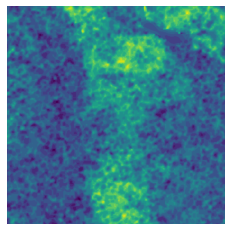

In [14]:
d=path+"Data/DEM/Bolivia_290290_DEM.tif"
DEM_data=tifffile.imread(d)
plt.imshow(DEM_data[0])
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

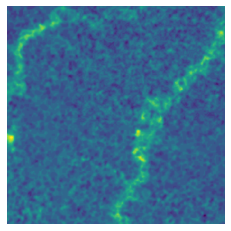

In [21]:
d=path+"Data/DEM/Bolivia_379434_DEM.tif"
DEM_data=tifffile.imread(d)
plt.imshow(DEM_data[0])
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

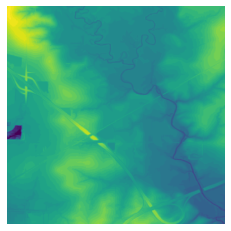

In [19]:
name=list_test[4]
dem=path+"Data/DEM/"+name+"_DEM.tif"
DEM_data=tifffile.imread(dem)
plt.imshow(DEM_data[0])
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

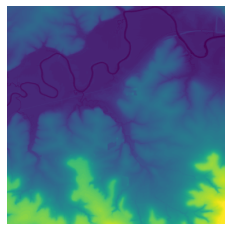

In [20]:
name=list_test[15]
dem=path+"Data/DEM/"+name+"_DEM.tif"
DEM_data=tifffile.imread(dem)
plt.imshow(DEM_data[0])
plt.axis("off")

In [189]:
S1_data=np.nan_to_num(tifffile.imread(pic))
arr_x = np.clip(S1_data, -50, 1)
arr_x = (arr_x + 50) / 51
S1_0_NORM = arr_x[0]
S1_1_NORM = arr_x[1]

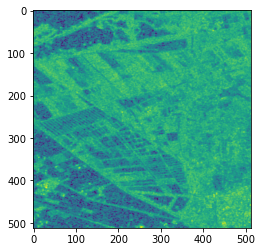

In [191]:
plt.imshow(S1_1_NORM)

In [9]:
DEM_data=tifffile.imread(dem)

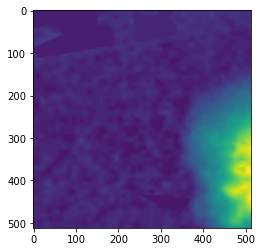

In [12]:
plt.imshow(DEM_data[0])

In [194]:
Label_data=np.uint8(rasterio.open(mas).read())
Label_data[Label_data==255]=0

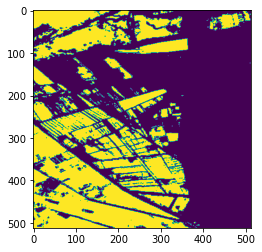

In [195]:
plt.imshow(Label_data[0])

In [196]:
NET=UNet()
checkpoint = torch.load(path+mod)
NET.load_state_dict(checkpoint)

<All keys matched successfully>

In [197]:
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=1)
inputs=SUM.unsqueeze(0)

In [198]:
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()

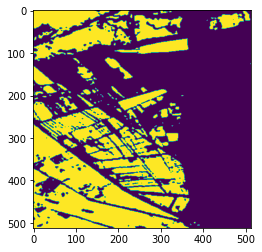

In [199]:
plt.imshow(a[0])


In [11]:
max_valid_iou

tensor(0.7511, device='cuda:0')

In [ ]:
rain_validation_loop(model, optimizer, train_dataloader, val_dataloader, 5, i)
    epochs.append(i)
    x = epochs
    plt.plot(x, training_losses, label='training losses')
    plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(x, training_ious, 'tab:purple', label='training iou')
    plt.plot(x, valid_losses, label='valid losses')
    plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
    plt.plot(x, valid_ious, 'tab:green',label='valid iou')
    plt.legend(loc="upper left")

    display(plt.show())

    print("max valid iou:", max_valid_iou)

In [15]:
x=[]
for i in range(0,500):
    x.append(i)

In [19]:
import pandas as pd

In [20]:
result =pd.DataFrame(columns=('epochs','t_loss','t_acc','t_iou','v_loss','v_acc','v_iou'))

In [23]:
result["epochs"]=x

In [25]:
result["t_loss"]=training_losses
result["t_acc"]=training_accuracies
result["t_iou"]=training_ious
result["v_loss"]=valid_losses
result["v_acc"]=valid_accuracies
result["v_iou"]=valid_ious

In [29]:
result.to_csv("new_i1i2dem_500.csv")

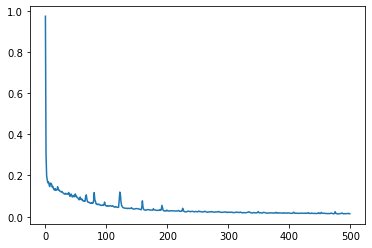

In [17]:
plt.plot(x, training_losses, label='training losses')

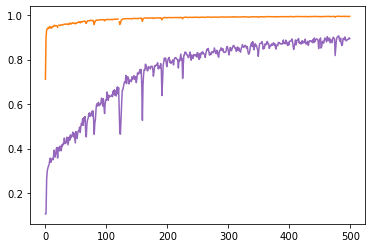

In [18]:
    plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
    plt.plot(x, training_ious, 'tab:purple', label='training iou')

In [10]:
from torchsummary import summary

In [13]:
summary(model,(1,1536,512))

/home/yylab/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              80
       BatchNorm2d-2          [-1, 8, 512, 512]              16
              ReLU-3          [-1, 8, 512, 512]               0
            Conv2d-4          [-1, 8, 512, 512]             584
       BatchNorm2d-5          [-1, 8, 512, 512]              16
              ReLU-6          [-1, 8, 512, 512]               0
            Conv2d-7         [-1, 16, 512, 512]           1,168
       BatchNorm2d-8         [-1, 16, 512, 512]              32
              ReLU-9         [-1, 16, 512, 512]               0
           Conv2d-10         [-1, 16, 512, 512]           2,320
      BatchNorm2d-11         [-1, 16, 512, 512]              32
             ReLU-12         [-1, 16, 512, 512]               0
           Conv2d-13          [-1, 8, 512, 512]              80
      BatchNorm2d-14          [-1, 8, 5

In [11]:
import matplotlib.pyplot as plt

In [1]:
root_dir="/home/yylab/Research/Flood/Sen1Floods11_all/Project/Data/"
test_path=root_dir+"txt/test.txt"
with open(test_path, "r") as test:
    lines_test =test.readlines()
    list_test=[i[:-1] for i in lines_test]

In [7]:
mod="Final/checkpoint/480_0.7510523200035095.pth"
path="/home/yylab/Research/Flood/Sen1Floods11_all/Project/"
name=list_test[1]
pic=path+"Data/S1/"+name+"_S1Hand.tif"
mas=path+"Data/Label/"+name+"_LabelHand.tif"
dem=path+"Data/DEM/"+name+"_DEM.tif"

In [8]:
S1_data=np.nan_to_num(tifffile.imread(pic))
arr_x = np.clip(S1_data, -50, 1)
arr_x = (arr_x + 50) / 51
S1_0_NORM = arr_x[0]

S1_1_NORM = arr_x[1]
DEM_data=tifffile.imread(dem)
Label_data=np.uint8(rasterio.open(mas).read())
Label_data[Label_data==255]=0


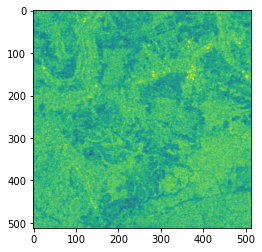

In [11]:
plt.imshow(S1_1_NORM)


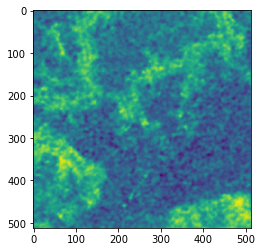

In [12]:
plt.imshow(DEM_data[0])



In [21]:
Label_data=np.uint8(rasterio.open(mas).read())
Label_data[Label_data==255]=0

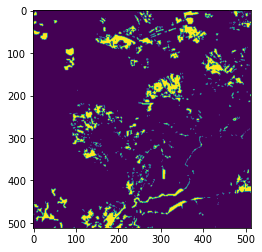

In [22]:
plt.imshow(Label_data[0])


/home/yylab/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


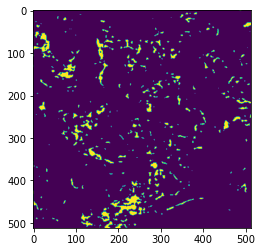

In [25]:
NET=UNet()
checkpoint = torch.load(path+mod)
NET.load_state_dict(checkpoint)
S10NORM = np.expand_dims(S1_0_NORM, axis=0)
S11NORM = np.expand_dims(S1_1_NORM, axis=0)
S0_NORM = torch.from_numpy(S10NORM).type(torch.FloatTensor)
S1_NORM = torch.from_numpy(S11NORM).type(torch.FloatTensor)
DEM_NORM=(DEM_data - np.min(DEM_data)) / (np.max(DEM_data) - np.min(DEM_data))
DEM = torch.from_numpy(DEM_NORM).type(torch.FloatTensor)
SUM = torch.cat((S0_NORM,S1_NORM,DEM),dim=1)
inputs=SUM.unsqueeze(0)
NET = NET.eval()
NET = NET.to(device)
out = NET(inputs.to(device))
a= torch.argmax(out, dim=1).cpu().numpy()
plt.imshow(a[0])